In [1]:
import numpy as np
import matplotlib.pyplot  as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel
from keras import metrics
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
copypath = '/content/drive/My Drive/data/lightcurve_array.npz'
npz=np.load(copypath)
xdata=npz['lc'][:,:-1] # to make the legth of the two concatenated light curves an even number
ydata=npz['delay']*1e3 # convert to human erad units
xdata.shape

(9999, 9998)

In [4]:
xdata = xdata/np.max(xdata,axis=1)[:,np.newaxis]

Delay is 49.97


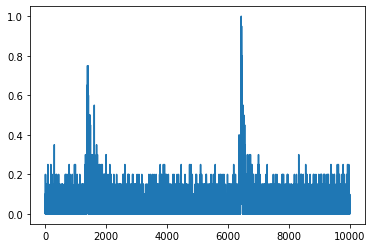

In [5]:
lc0 = xdata[0]
plt.plot(lc0)
print("Delay is {:.2f}".format(ydata[0]))

In [6]:
def ccf(x):
  half = len(x)//2
  a, b = x[0:half], x[half:]
  a = (a - np.mean(a)) / (np.std(a) * len(a))
  b = (b - np.mean(b)) / (np.std(b))
  return np.correlate(a,b,'same')

In [7]:
def ccf_cumsum(x,dd=False):
  half = len(x)//2 
  cs1 = np.cumsum(x[0:half])
  cs2 = np.cumsum(x[half:])
  cs1 /= np.max(cs1)
  cs2 /= np.max(cs2)
  if dd:
    cs1 = np.diff(np.diff(cs1))
    cs2 = np.diff(np.diff(cs2))
  return np.correlate(cs1,cs2,'same')

2448

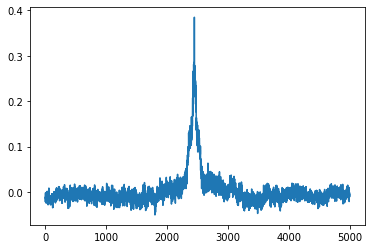

In [8]:
ccf_lc0 = ccf(lc0)
plt.plot(ccf_lc0)
np.argmax(ccf_lc0)

In [9]:
ccfdata = np.apply_along_axis(func1d=ccf, axis=1, arr=xdata)

In [10]:
ccfdata.shape

(9999, 4999)

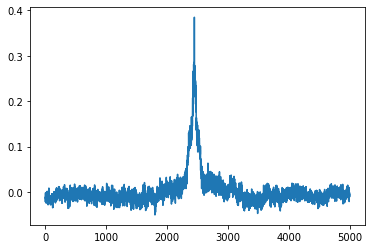

In [11]:
ccfdata_preview =  ccfdata[0]
plt.plot(ccfdata_preview)

Mean = 8.526513e-17, std = 1.000


(9999, 500)

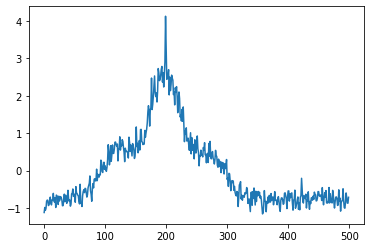

In [12]:
nbins_full = ccfdata.shape[1]
window_size = 500
xtrain = np.copy(ccfdata[:,nbins_full//2-window_size//2:nbins_full//2+window_size//2])
#z = (x - u) / s
xtrain = (xtrain - np.mean(xtrain, axis=1)[:,None])/np.std(xtrain,axis=1)[:,None]
plt.plot(xtrain[0])
print('Mean = {:e}, std = {:.3f}'.format( np.mean(xtrain[0]), np.std(xtrain[0])) )
xtrain.shape

In [15]:
def gprocess(x, downsample=2):
  n = len(x)
  kernel = 1.0*RBF(2.0) + WhiteKernel()
  gp = GaussianProcessRegressor(kernel=kernel, random_state=0)
  X = np.atleast_2d(np.linspace(0,n,n)).T
  y = np.atleast_2d(x).T
  gp.fit(X,y)
  X2 = np.atleast_2d(np.linspace(0, n, downsample*n)).T
  f = gp.predict(X2)
  return f.ravel()

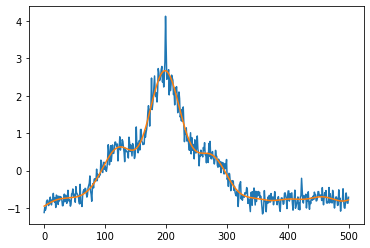

In [16]:
downsample = 4
gp_smooth = gprocess(xtrain[0], downsample=downsample)
n = len(xtrain[0])
plt.plot(np.linspace(0, n, n), xtrain[0])
plt.plot(np.linspace(0, n, downsample*n), gp_smooth)

In [17]:
Nsamples = xtrain.shape[0]
kernel = 1.0*RBF(2.0) + WhiteKernel()
gp = GaussianProcessRegressor(kernel=kernel, random_state=0)
X = np.atleast_2d(np.linspace(0,n,n)).T
X2 = np.atleast_2d(np.linspace(0, n, downsample*n)).T
xtrain_smooth = np.empty((Nsamples, downsample*n))

In [ ]:
for i in range(Nsamples):
  y = xtrain[i,:]
  gp.fit(X,y)
  if i%100 == 
  if i%1000 == 0:
    print(f'Step {i}', end =" ")
  xtrain_smooth[i,:] = gp.predict(X2)

In [ ]:
np.savez('/content/drive/My Drive/data/xtrain.npz',xtrain)

In [ ]:
np.savez('/content/drive/My Drive/data/xtrain_smooth.npz',xtrain_smooth)

In [ ]:
# xtrain_smooth = np.apply_along_axis(func1d=gprocess, axis=1, arr=xtrain, downsample=4)

In [92]:
X_train, X_test, y_train, y_test = train_test_split(xtrain, ydata, test_size=0.30, random_state=0)
orig_dim=X_train[0].shape
X_train.shape, y_train.shape, orig_dim

((6999, 500), (6999,), (500,))

In [93]:
model = Sequential() # 48, 24
model.add(Dense(units=32, input_shape=(orig_dim),activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(units=24,activation='sigmoid'))
model.add(Dense(units=1))
m=[metrics.mean_squared_error, metrics.mean_absolute_error]
model.compile(loss='mean_squared_error', optimizer='adamax', metrics=m)

In [94]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 32)                16032     
_________________________________________________________________
dropout_13 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 24)                792       
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 25        
Total params: 16,849
Trainable params: 16,849
Non-trainable params: 0
_________________________________________________________________


In [95]:
nepochs = 100
batch_size = 100
h = model.fit(X_train,y_train,epochs=nepochs,batch_size=batch_size, validation_data=(X_test,y_test), verbose=0)

In [96]:
# h = estimator.fit(X_train, y_train, validation_data=(X_test,y_test))

In [97]:
# model.save('/content/drive/My Drive/data/my_ccfmodel')

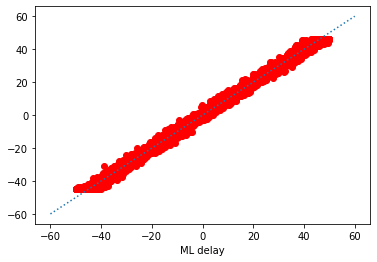

In [98]:
y_pred = model.predict(X_test)
plt.scatter(y_test,y_pred,color="r")
plt.xlabel("True delay")
plt.xlabel("ML delay")
plt.plot([-0.06*1e3,0.06*1e3],[-0.06*1e3,0.06*1e3],':')
plt.xlim([-0.06*1e3,0.06*1e3])
plt.ylim([-0.06*1e3,0.06*1e3])

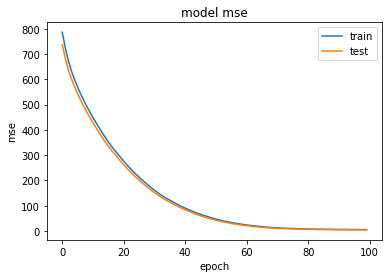

In [99]:
# summarize history for loss
plt.plot(h.history['mean_squared_error'], label='train')
plt.plot(h.history['val_mean_squared_error'], label='test')
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend()

In [100]:
def howGoodAmI(y_test, y_pred):
  diff = y_test - y_pred.ravel()
  hist = plt.hist(diff)
  bincentres = (hist[1][:-1]+hist[1][1:])/2.
  weights = hist[0]
  mu = np.average(bincentres,weights=weights)
  sigma = np.average((bincentres-mu)**2, weights=weights)
  return mu, sigma

(-0.08923667015517345, 4.364296623117846)

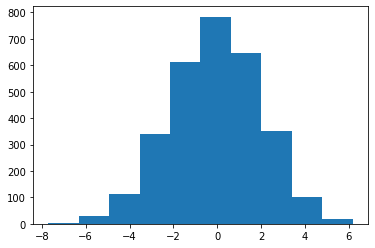

In [101]:
howGoodAmI(y_test, y_pred)

In [ ]:
#scaler = StandardScaler()
#X_train_ = scaler.fit_transform(X_train)
#pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train)

In [102]:
gbr = GradientBoostingRegressor(random_state=0)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

(-60.0, 60.0)

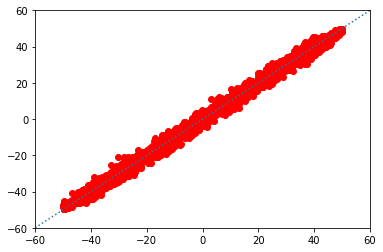

In [103]:
y_pred = gbr.predict(X_test)
plt.scatter(y_test,y_pred,color="r")
plt.plot([-0.06*1e3,0.06*1e3],[-0.06*1e3,0.06*1e3],':')
plt.xlim([-0.06*1e3,0.06*1e3])
plt.ylim([-0.06*1e3,0.06*1e3])

(0.03734270257826624, 4.678597949711111)

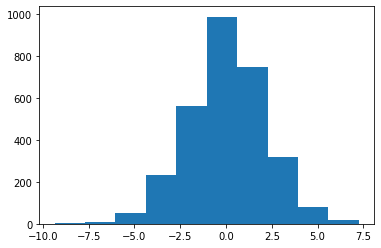

In [104]:
howGoodAmI(y_test, y_pred)

In [106]:
len(np.unique(ydata)), len(np.unique(np.around(ydata, decimals=2)))

(9999, 6312)

In [ ]:
ydata[0], np.around(ydata[0], decimals=4)

(0.0499741748906672, 0.05)